## Лабораторна робота 6. **Unsupervised Learning**

Оцінювання даної роботи буде ураховувати якість Ваших висновків та візуалізацій. При наявності ЛИШЕ коду та візуалізацій без роз'яснень, робота оцінюватися НЕ БУДЕ.  

Більшість поставлених в цій лабораторній роботі задач в майбутньому буде ставитись Вами самойстійно!

Під час виконання Вам дозволено користуватися будь-якими зручними для вас бібліотеками для візуалізації. 

Оформлення коментарів повинно проводитися в текстових комірках ноутбука з використанням синтаксису [LaTeX](https://en.wikibooks.org/wiki/LaTeX/Basics) для оформлення тексту та формул. 

Роботи ідентифіковані як ІДЕНТИЧНІ одразу отримують 0 балів.

## Кластерування  

В цій лабораторній роботі Ви будете вирішувати задачу класифікації БЕЗ вчителя. 

In [116]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline 

import os
import warnings


warnings.filterwarnings('ignore')
dataset=pd.read_csv('Mall_Customers.csv')

**Завдання 0** 

Для початку необхідно завантажити вибірку `Mall_Customers` і перейменувати атрибути `Annual Income (k$)` в `Income`,`Spending Score (1-100)` в `SpendingScore`

In [4]:
dataset = dataset.rename(columns={'Annual Income (k$)': 'Income',
                                  'Spending Score (1-100)': 'SpendingScore'})

print(dataset.head())

   CustomerID  Gender  Age  Income  SpendingScore
0           1    Male   19      15             39
1           2    Male   21      15             81
2           3  Female   20      16              6
3           4  Female   23      16             77
4           5  Female   31      17             40


**Завдання 1** 

Підготовка даних до опрацювання

* подивитись які атрибути містить вибірка; 
* вивести розмірність датасету;
* вивести основну статистичну інформацію по числовим змінним;  
* перевірити на наявність `NaN`.   

In [6]:
attributes = list(dataset.columns)

print(attributes)

['CustomerID', 'Gender', 'Age', 'Income', 'SpendingScore']


In [7]:
dataset_shape = dataset.shape

print("Dataset shape:", dataset_shape)

Dataset shape: (200, 5)


## EDA Mall Customers

**Завдання 2** 

Як Ви могли помітити по статистичній аналітиці вибірки вона містить змінну `CustomerID`. Ця змінна не впливає на аналіз даних тому її можна видалити.

In [13]:
dataset = dataset.drop('CustomerID', axis=1)

print(dataset.columns)

Index(['Gender', 'Age', 'Income', 'SpendingScore'], dtype='object')


**Завдання 3** 

Побудувати діаграми розподілу по змінним `Age` , `Income` та `SpendingScore`

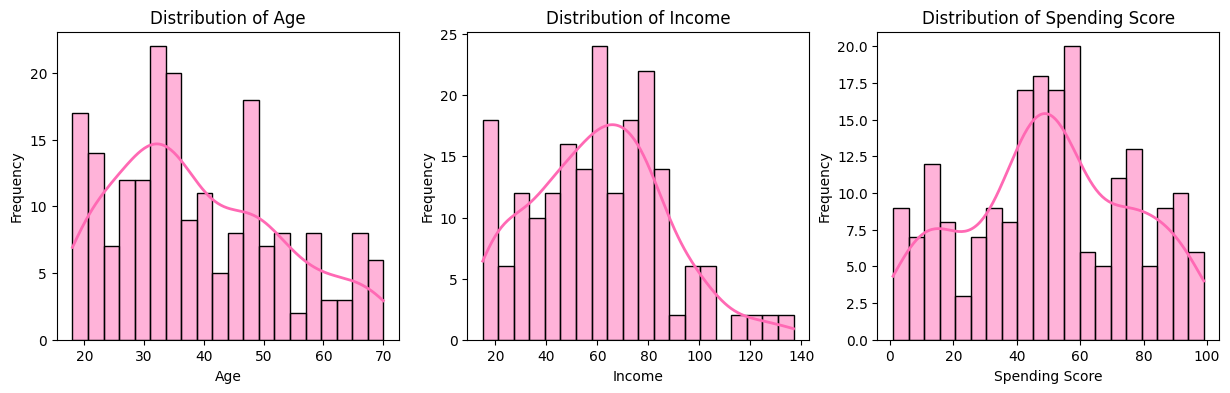

In [27]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.histplot(data=dataset, x='Age', bins=20, kde=True, color='hotpink', line_kws={'linewidth': 2, 'alpha': 1})
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')

plt.subplot(1, 3, 2)
sns.histplot(data=dataset, x='Income', bins=20, kde=True, color='hotpink', line_kws={'linewidth': 2, 'alpha': 1})
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Distribution of Income')

plt.subplot(1, 3, 3)
sns.histplot(data=dataset, x='SpendingScore', bins=20, kde=True, color='hotpink', line_kws={'linewidth': 2, 'alpha': 1})
plt.xlabel('Spending Score')
plt.ylabel('Frequency')
plt.title('Distribution of Spending Score')

plt.show()

**Завдання 4** 

Давайте подивимось на ці змінні `Age` , `Income` та `SpendingScore` відносно змінної `Gender`. 
* Побудуємо `pairplot` по всім змінним відностно змінної `Gender`:  
 
* Побудуємо `pairplot` використовуючи `sns.PairGrid` із заданими `(scatterplot)`, `(kdeplot)` та `(kdeplot, lw=1)` по відповідно правому верхньому куту, діагоналі і лівому нижньому кутут відносно змінної `Gender`:  
 

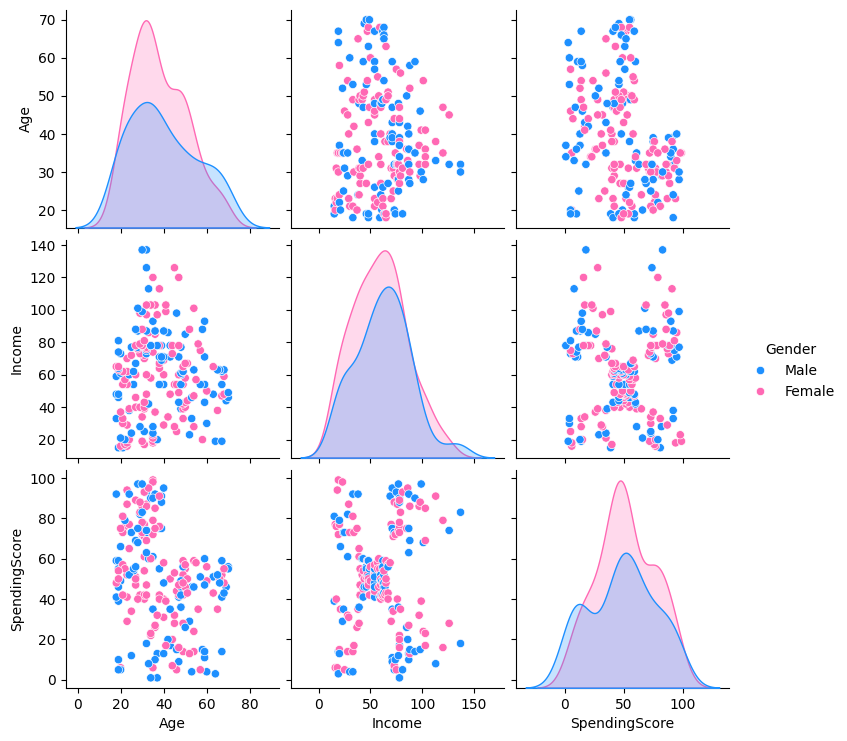

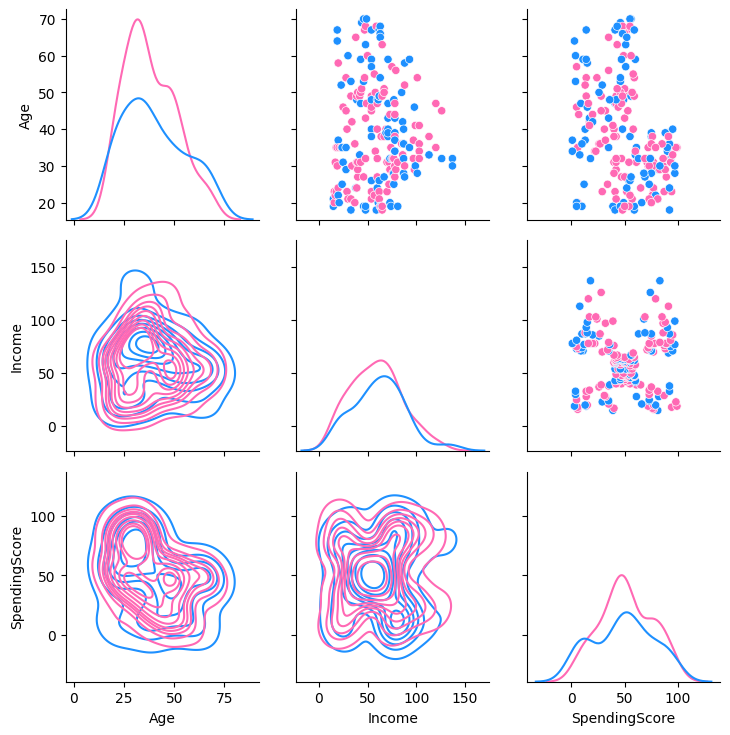

In [43]:
color_dict = {'Female': 'hotpink', 'Male': 'dodgerblue'}
sns.pairplot(data=dataset, vars=['Age', 'Income', 'SpendingScore'], hue='Gender', palette=color_dict)
plt.show()

g = sns.PairGrid(data=dataset, vars=['Age', 'Income', 'SpendingScore'], hue='Gender', palette=color_dict)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, lw=1)
plt.show()

**Висновки з 1-4 завдання (детальні)**

1.   На основі виведення списку атрибутів датасету Mall_Customers та його розміру, можна зробити висновок, що датасет містить 5 атрибутів: 'CustomerID', 'Gender', 'Age', 'Income', 'SpendingScore' та 200 записів. Це означає, що в датасеті є інформація про 200 клієнтів, для кожного з яких надано інформацію про стать, вік, дохід та витрати. Розмір датасету (200, 5) вказує на те, що він має 200 рядків та 5 стовпців.
2. На основі виведення стовпців датасету після видалення атрибуту 'CustomerID', можна зробити висновок, що датасет Mall_Customers тепер містить 4 атрибути: 'Gender', 'Age', 'Income', 'SpendingScore'. Це означає, що в датасеті все ще є інформація про 200 клієнтів, але тепер без унікального ідентифікатора клієнта 'CustomerID'. Залишились лише атрибути, що містять інформацію про стать, вік, дохід та витрати кожного клієнта.
3. У датасеті чоловіки та жінки представлені майже рівномірно, хоча чоловіки мають невелику перевагу в деяких вікових групах. Діаграми розсіювання демонструють, що немає значної різниці між статями щодо річного доходу та оцінки витрат. Контурні графіки (kdeplot) вказують на те, що серед молодших вікових груп спостерігається деяка концентрація вищих оцінок витрат. Жінки мають трохи вищі оцінки витрат у порівнянні з чоловіками. 
4. Чоловіки та жінки майже однаково представлені у датасеті, з невеликою перевагою чоловіків у деяких вікових групах.
Діаграми розсіювання (scatterplot) показують, що немає виразної відмінності між статями щодо річного доходу та оцінки витрат. Тобто, як чоловіки, так і жінки мають подібний рівень доходу та витрат.
Контурні графіки (kdeplot) вказують на деяку концентрацію вищих оцінок витрат серед молодших вікових груп, як для чоловіків, так і для жінок.
Жінки мають трохи більш високі оцінки витрат у порівнянні з чоловіками, що може свідчити про деякі відмінності у споживчих звичках.
Як чоловіки, так і жінки показують зниження рівня витрат з віком, особливо після 40 років. Це може бути пов'язано зі зміною споживчих пріоритетів та зміною рівня доходу з віком.

**Завдання 5** 

Проаналізувати змінну `Gender`:
* вивести співвідношення по статям;
* побудувати `countplot` по `Gender`;  
* побудувати `pie` по `Gender'.  

In [44]:
gender_counts = dataset['Gender'].value_counts()
print(gender_counts)

Gender
Female    112
Male       88
Name: count, dtype: int64


**Завдання 6** 

Побудувати гістограми [histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html) змінних `Age` та `Income` відносно змінної `Gender` з різними параметрами:
*  подивитись на скільки змінюється візуалізація при різних значеннях параметра `multiple`, наприклад `dodge` та `layer`.

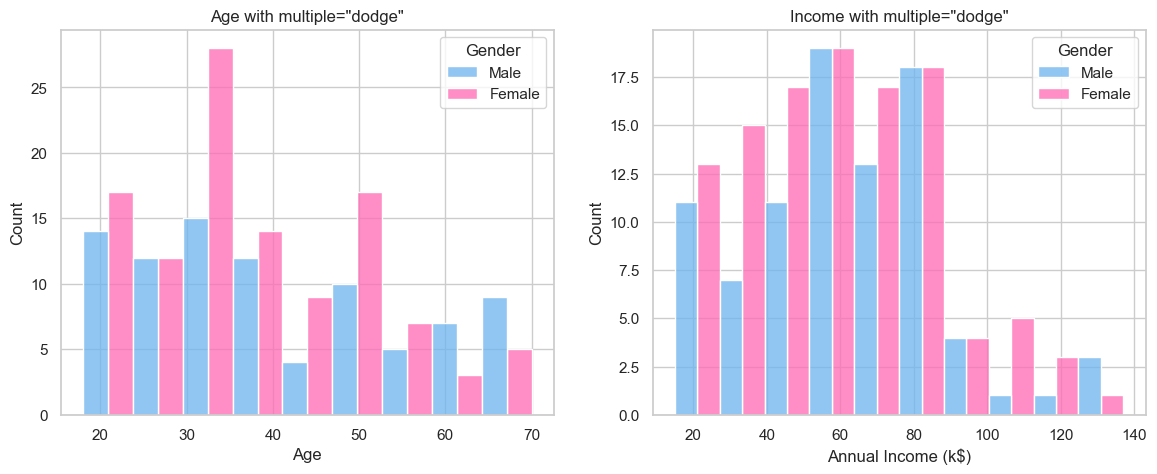

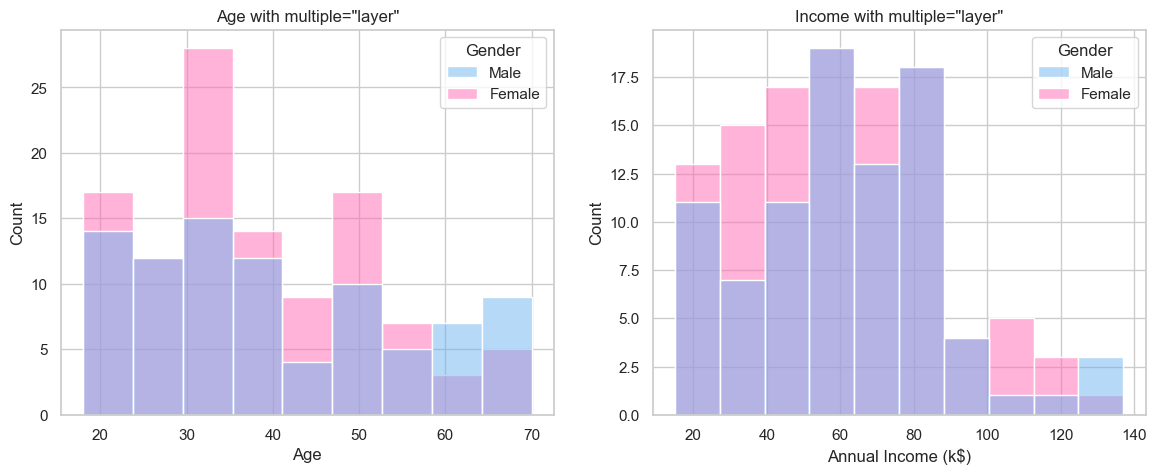

In [120]:
color_dict = {'Female': 'hotpink', 'Male': '#6CB4EE'}

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=dataset, x='Age', hue='Gender', multiple='dodge', kde=False, palette=color_dict)
plt.title('Age with multiple="dodge"')

plt.subplot(1, 2, 2)
sns.histplot(data=dataset, x='Annual Income (k$)', hue='Gender', multiple='dodge', kde=False, palette=color_dict)
plt.title('Income with multiple="dodge"')

plt.show()

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=dataset, x='Age', hue='Gender', multiple='layer', kde=False, palette=color_dict)
plt.title('Age with multiple="layer"')

plt.subplot(1, 2, 2)
sns.histplot(data=dataset, x='Annual Income (k$)', hue='Gender', multiple='layer', kde=False, palette=color_dict)
plt.title('Income with multiple="layer"')

plt.show()


**Завдання 7** 

Побудувати гістограми [histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html) змінної `SpendingScore` відносно змінної `Gender` з різними параметрами:  
* подивитись на скільки змінюється візуалізація при різних значеннях параметра `multiple`, наприклад `dodge` та `layer`. 



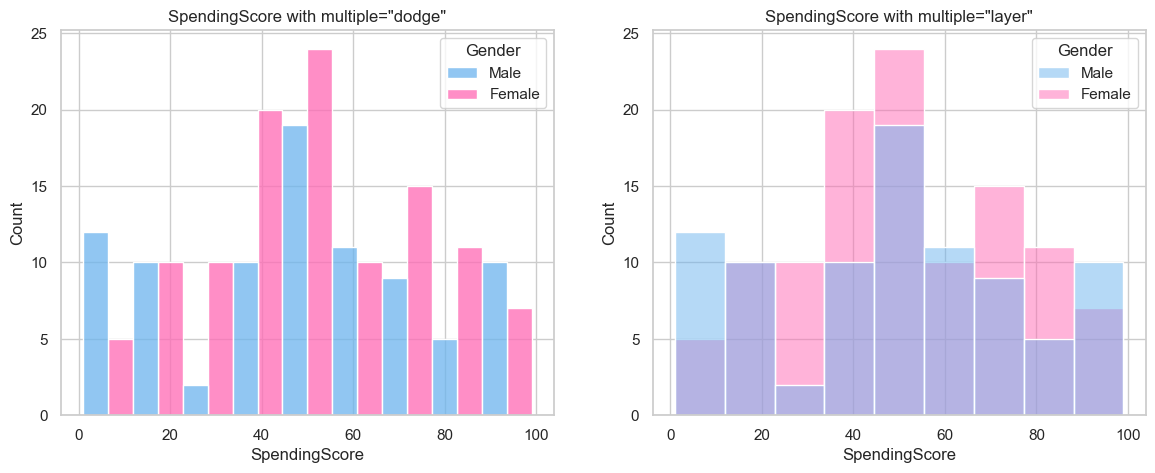

In [69]:
color_dict = {'Female': 'hotpink', 'Male': '#6CB4EE'}

plt.figure(figsize=(14, 5)) 

plt.subplot(1, 2, 1)  
sns.histplot(data=dataset, x='SpendingScore', hue='Gender', multiple='dodge', kde=False, palette=color_dict)
plt.title('SpendingScore with multiple="dodge"')

plt.subplot(1, 2, 2)  
sns.histplot(data=dataset, x='SpendingScore', hue='Gender', multiple='layer', kde=False, palette=color_dict)
plt.title('SpendingScore with multiple="layer"')

plt.show()

**Завдання 8** 

Побудувати `boxplot` по змінній `SpendingScore` і подивитись як відрізняються витрати відностно змінної `Gender`. 

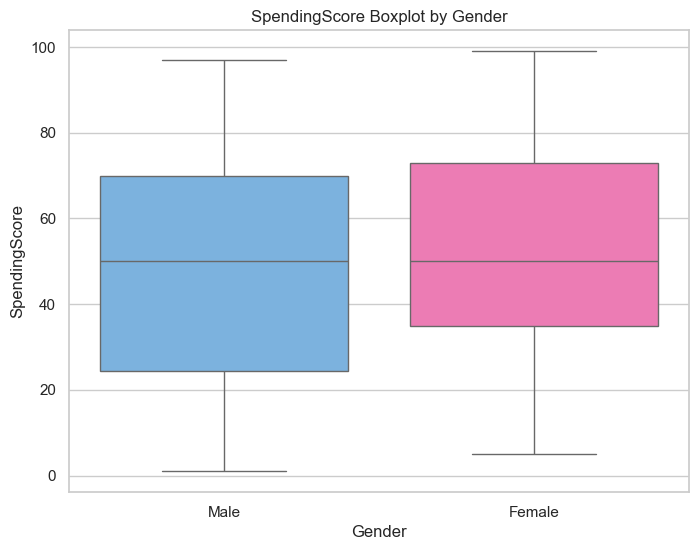

In [70]:
color_dict = {'Female': 'hotpink', 'Male': '#6CB4EE'}

plt.figure(figsize=(8, 6))  
sns.boxplot(x='Gender', y='SpendingScore', data=dataset, palette=color_dict)
plt.title('SpendingScore Boxplot by Gender')
plt.show()

**Висновки з завдання 5 - 8(детальні)**

1.  На основі результатів функції `value_counts()`, ми можемо зробити висновок, що у вибірці більше жінок, ніж чоловіків. Кількість жінок становить 112, а кількість чоловіків - 88.
2.  Гістограми змінних Age та Income, представлені за статтю, демонструють, що жінки та чоловіки досить рівномірно розподілені по вікових категоріях та доходах. Проте, інформація про витрати за статтю відсутня, що унеможливлює детальний аналіз розподілу витрат. Для проведення такого аналізу необхідно скористатися змінною SpendingScore, розділеною за статтю, що дозволить виявити відмінності у споживчих звичках.
3. Аналіз змінної SpendingScore, розділеної за статтю, показує, що існують відмінності у витратах між чоловіками та жінками. Зокрема, жінки, як правило, витрачають більше, ніж чоловіки, що може свідчити про різницю в звичках між статями. 
4. Жінки, загалом, мають вищий середній рівень витрат, ніж чоловіки

## K-means Method ##

**Завдання 9** 

Як Ви могли помітити, вибірка, з якою ми працюємо, не містить ключової зміної з вірними мітками. Тому перед початком кластерування необхідно визначити (підібрати) оптимальну кількість кластерів на яке буде проведено розбиття. Для цього необхідно:
1. видалити змінну `Gender`, тому що ... **Чому?**;  
2. задати мінімальну та максимальну кількість кластерів самостійно;  
3. На прикладі алгоритму [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), для ознайомлення з тим як працювати в умовах коли кількість кластерів невідома заздалегіть і немає вірних міток з позначками до якого кластеру відноситься спостереження пропонується використати метод [Elbow](https://coderoad.ru/19197715/Scikit-Learn-K-Means-Elbow-criterion) (додаткові джерела: [article_1](https://medium.com/analytics-vidhya/elbow-method-of-k-means-clustering-algorithm-a0c916adc540#:~:text=K%2Dmeans%20clustering%20is%20an,cluster%20with%20the%20nearest%20centroid.), [article_2](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/))

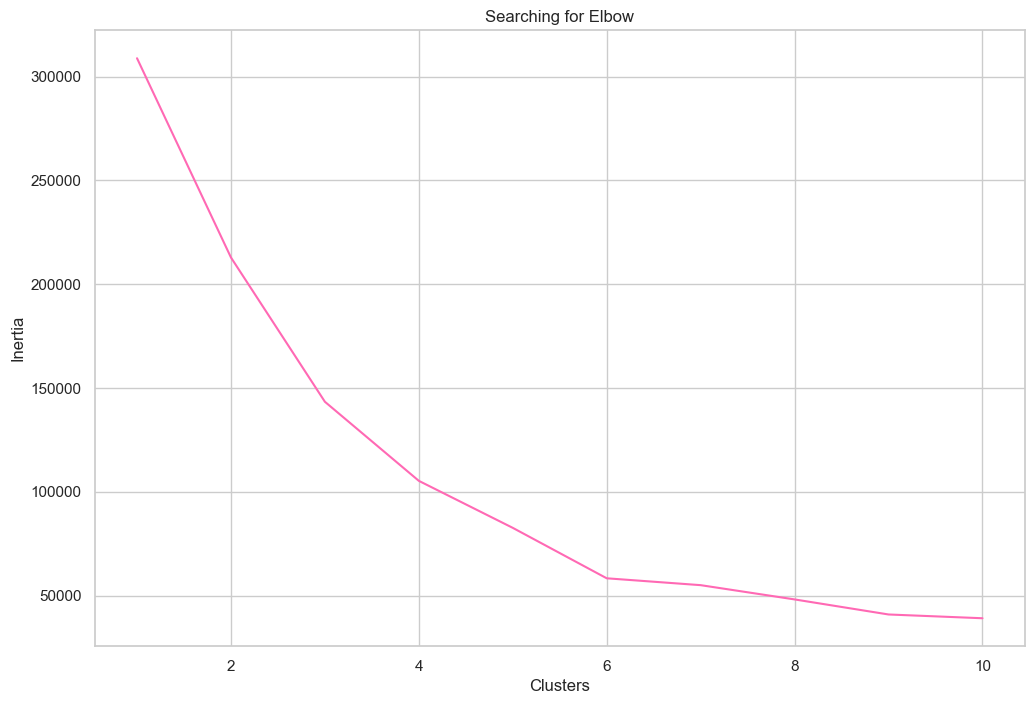

In [72]:
X = dataset.drop(['Gender'], axis=1)

min_clusters = 1
max_clusters = 10

clusters = []

for n_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    clusters.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax, color='hotpink')
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

plt.show()

**Висновки з завдання 9 (детальні)** 

Була проведена кластеризація даних, використовуючи алгоритм k-means, та взято до уваги різні параметри, крім статі.
* Для визначення оптимальної кількості кластерів, було побудувано графік залежності інерції від кількості кластерів.
* Графік показує, як змінюється інерція при збільшенні кількості кластерів від 1 до 10.
* Значення інерції зменшується зі збільшенням кількості кластерів, але після деякого значення кількості кластерів, воно зменшується незначно.
* Оптимальну кількість кластерів можна визначити, знайшовши "лікоть" на графіку, тобто місце, де відбувається різке зменшення інерції, а потім вона стабілізується.
На мою думку, оптимальною кількістю кластерів для даних є 3 або 4. Саме в цих точках спостерігається значне зменшення інерції, а потім вона стабілізується. 

**Завдання 10** 

Зробити двовимірну візуалізацію кластеризації методу К-середніх на вибраних Вами двох різних кількостях кластерів використовуючи змінні `Income` та `SpendingScore`. 

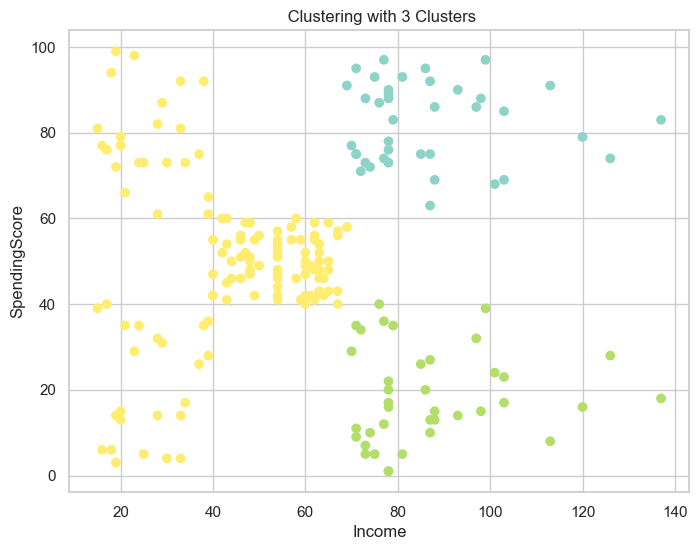

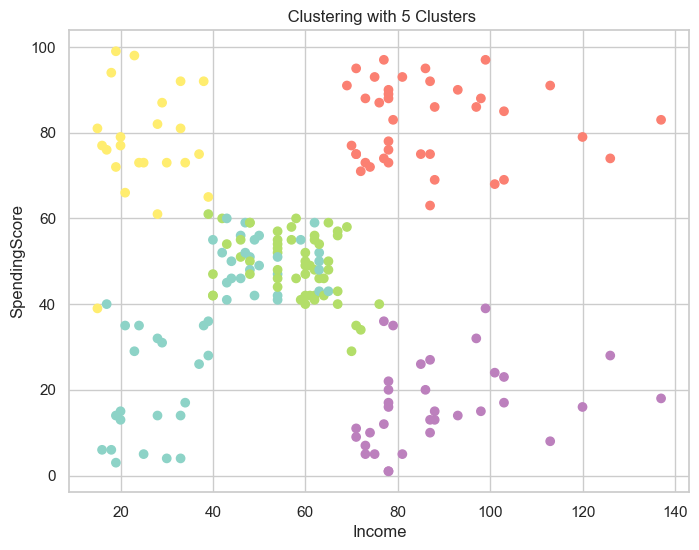

In [80]:
plt.figure(figsize=(8, 6))
plt.scatter(X['Income'], X['SpendingScore'], c=labels1, cmap='Set3')
plt.title(f' Clustering with {n_clusters1} Clusters')
plt.xlabel('Income')
plt.ylabel('SpendingScore')

plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X['Income'], X['SpendingScore'], c=labels2, cmap='Set3')
plt.title(f' Clustering with {n_clusters2} Clusters')
plt.xlabel('Income')
plt.ylabel('SpendingScore')

plt.show()


**Завдання 11** 

Зробити візуалізацію кластеризації методу К-середніх на вибраних Вами двох різних кількостях кластерів використовуючи [scatter_3d](https://plotly.com/python/3d-scatter-plots/).

In [92]:
X = dataset[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

num_clusters = [3, 5]

for n_clusters in num_clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(X)

    dataset['Cluster'] = kmeans.labels_

    fig = go.Figure(data=go.Scatter3d(x=X['Age'], y=X['Annual Income (k$)'], z=X['Spending Score (1-100)'],
                                      mode='markers', marker=dict(color=dataset['Cluster'],
                                                                  colorscale='Viridis')))
    fig.update_layout(title=f'Clustering with {n_clusters} clusters',
                      scene=dict(xaxis_title='Age',
                                 yaxis_title='Annual Income (k$)',
                                 zaxis_title='Spending Score (1-100)'))
    fig.show()

**Висновки з завдання 10 - 11 (детальні)** 

Була проведена кластеризація даних, за допомогою двох різних підходів.
* Перший підхід розділив дані на кілька груп, враховуючи доходи та витрати.
* Другий підхід також розділив дані на кілька груп, але з іншим розподілом.
* Обидва підходи показують, що групи мають різні рівні доходів та витрат.
* Візуалізація допомагає нам порівняти результати кластеризації та зрозуміти, як дані розподілені між групами.

Була проведена кластеризація даних, використовуючи алгоритм k-means, було взято до уваги вік, річний дохід та витрати.
* Кластеризацію проведено для двох варіантів кількості кластерів: 3 та 5.
* Візуалізація показує, як дані розподілені між кластерами в тривимірному просторі.
* Кожен кластер має різні рівні віку, річного доходу та витрат.
* Візуалізація допомагає нам порівняти результати кластеризації для різної кількості кластерів та зрозуміти, як дані розподілені між групами.

## Agglomerative clustering ##

Розглянемо ще один підхід до кластеризації - [агломеративну ієрархічну кластеризацію](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

**Завдання 12** 

Кластеризуйте датасет за допомогою [агломеративної ієрархічнуої кластеризації](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

Мінімально необхідні параметри, що треба налаштувати:  
* `n_clusters`: параметр, який відповідає за кільксіть кластерів на яку буде проведено розбиття вибірки;  
* `linkage`: параметр зв’язку. Цей параметр визначає, яку відстань використовувати між наборами спостережень.
* перевірте як працює цей метод з різними параметрами `linkage`  
* після кожної зміни параметрів - візуалізувати розбиття на кластери

Розрахувати матрицю відстаней для нашого набору даних:
* за допомогою методу [hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) і матриці відстаней кластеризувати дані з різними значеннями параметра `method`
* за допомогою методу [hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) візуалізувати отримані результати кластеризації у вигляді дендрограм


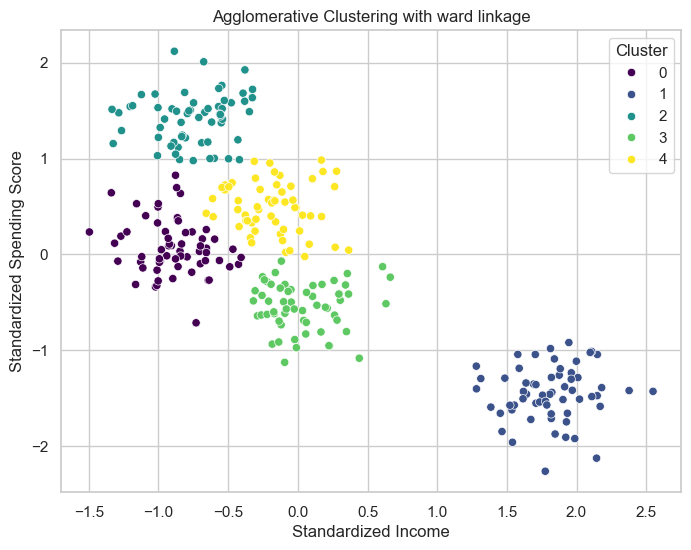

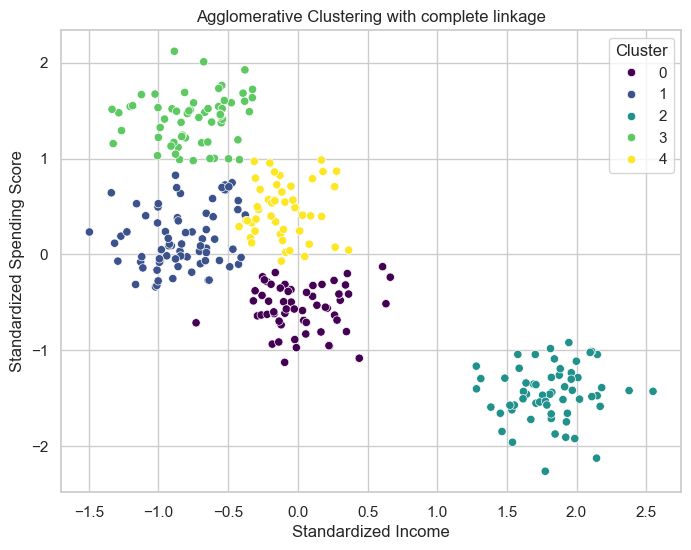

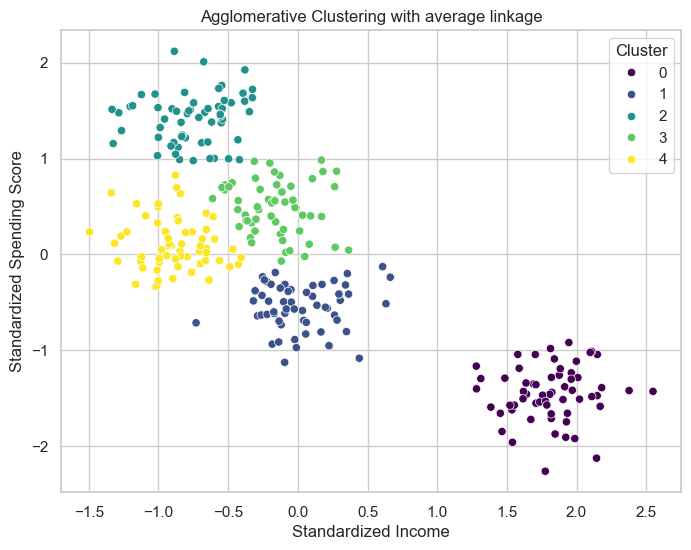

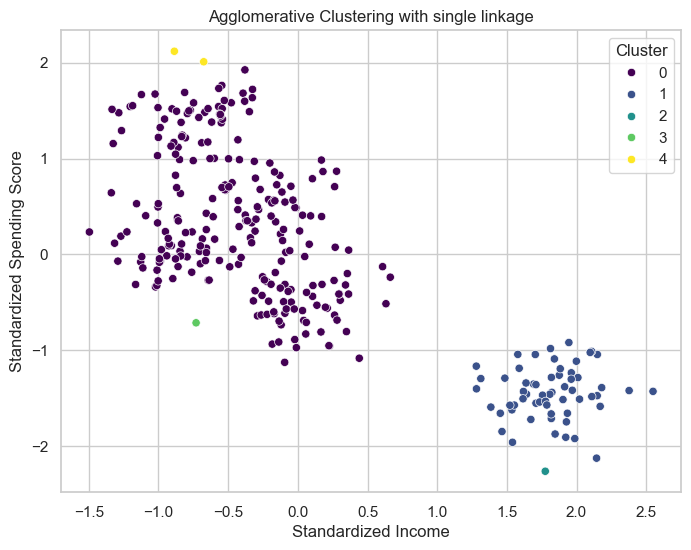

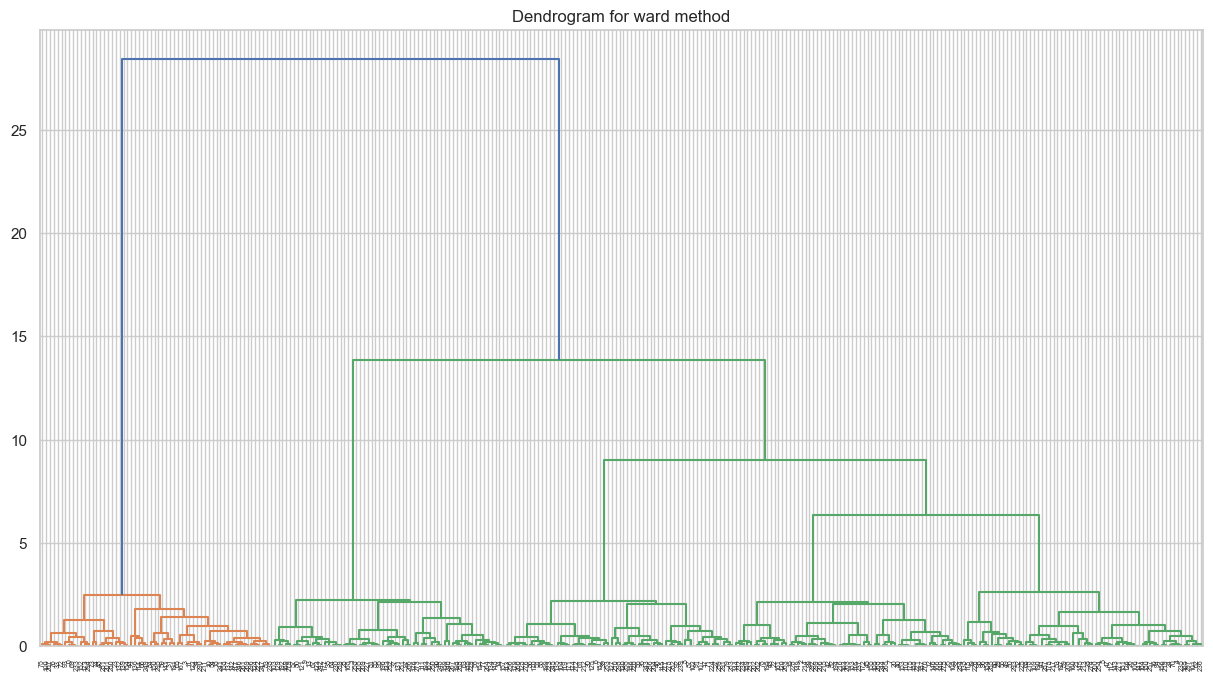

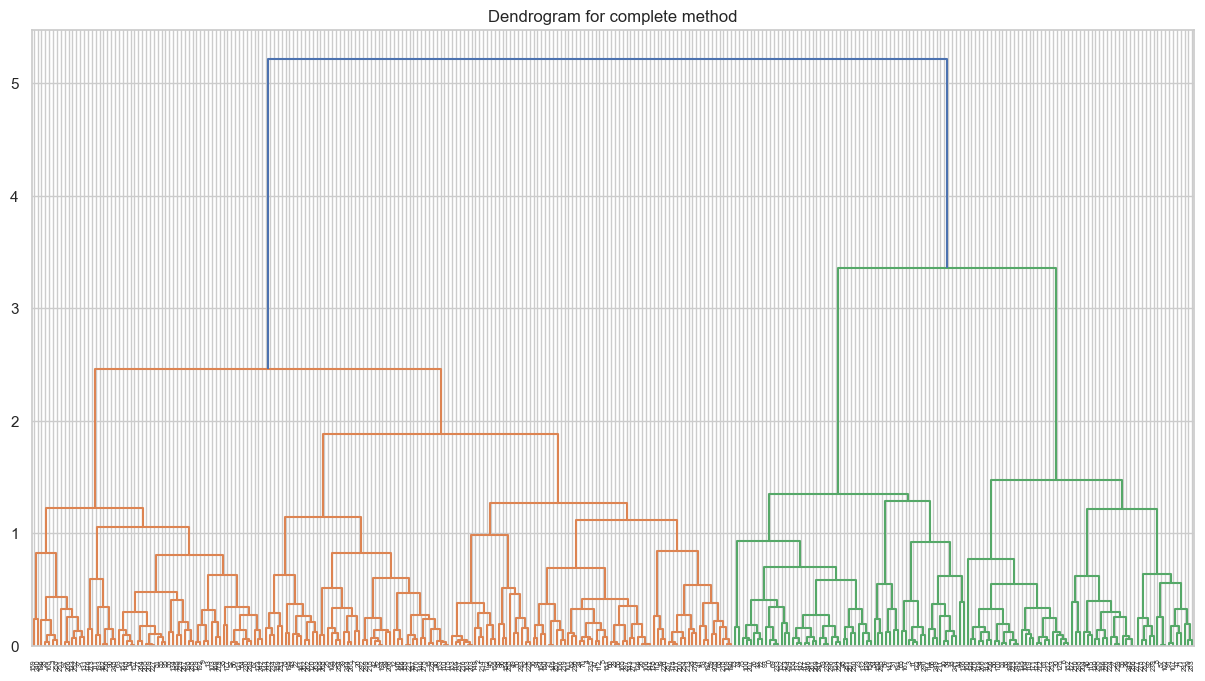

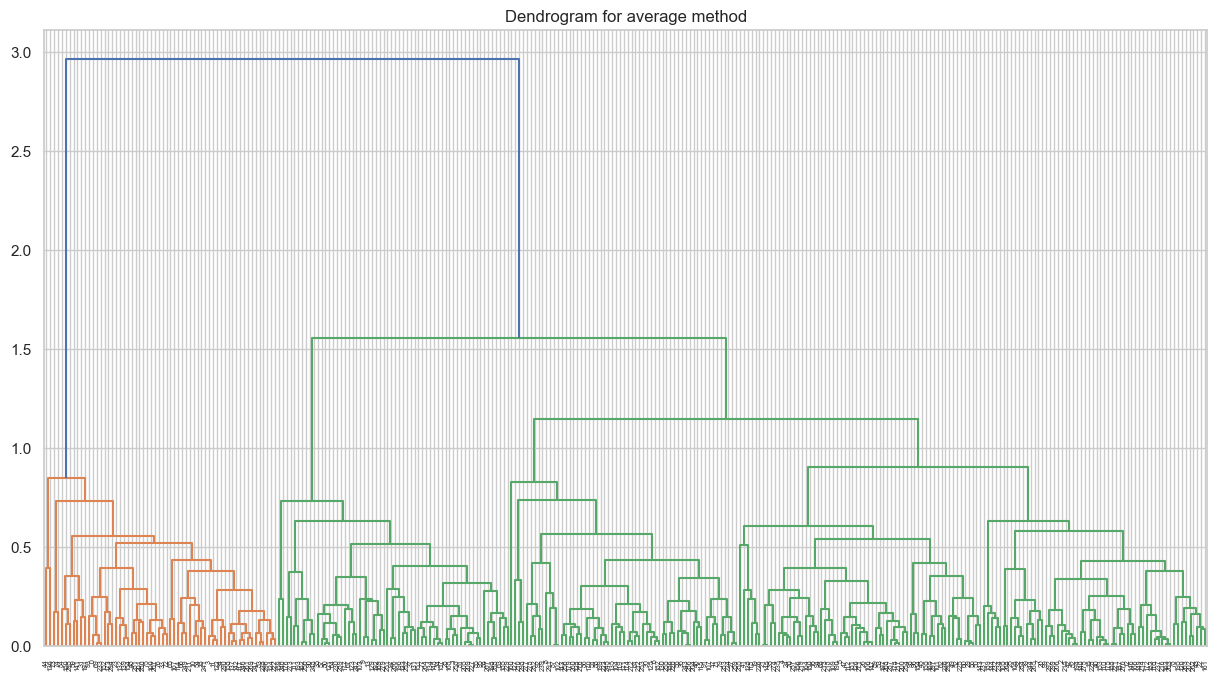

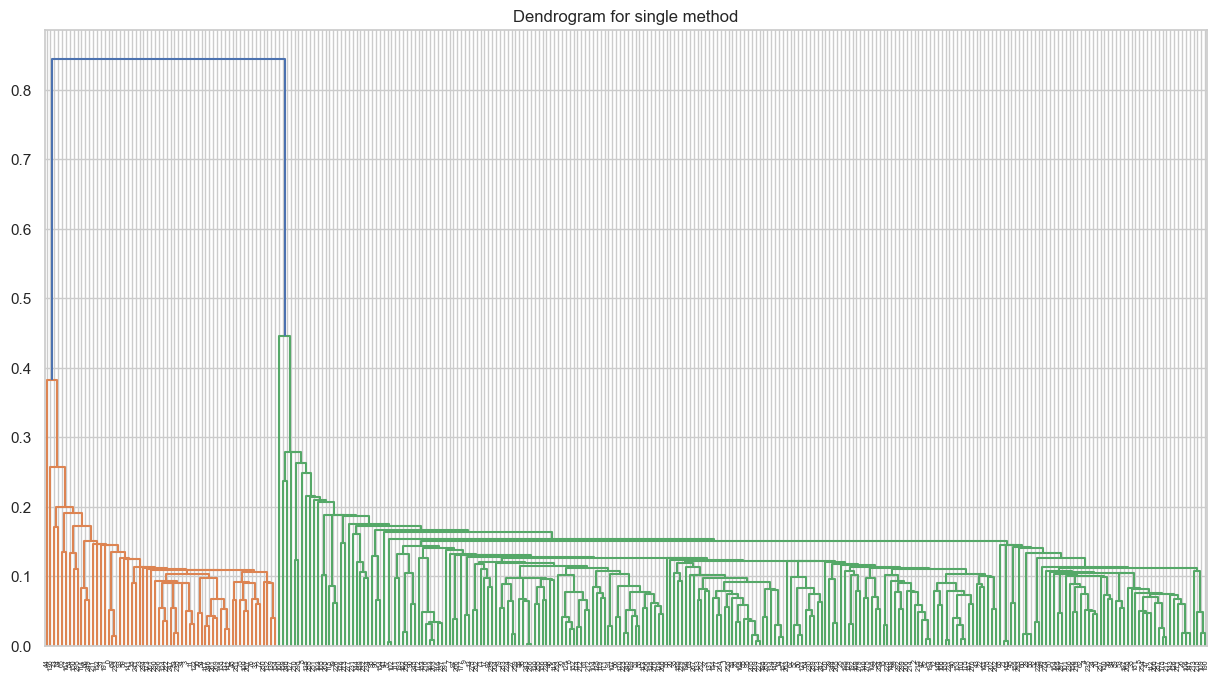

In [114]:
X, y_true = make_blobs(n_samples=300, centers=5, random_state=0)

linkage_methods = ['ward', 'complete', 'average', 'single']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for linkage_method in linkage_methods:
    clustering = AgglomerativeClustering(n_clusters=5, linkage=linkage_method)
    clustering.fit(X_scaled)
    labels = clustering.labels_

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, palette='viridis', legend='full')
    plt.title(f'Agglomerative Clustering with {linkage_method} linkage')
    plt.xlabel('Standardized Income')
    plt.ylabel('Standardized Spending Score')
    plt.legend(title='Cluster')
    
    plt.show()

for method in linkage_methods:
    Z = linkage(X_scaled, method=method)

    plt.figure(figsize=(15, 8))
    plt.title(f'Dendrogram for {method} method')
    dn = dendrogram(Z)

    plt.show()

**Висновки з завдання 12 (детальні)**

Після виконання ієрархічного кластерного аналізу з різними методами зв'язку, можна зробити такі висновки:

1. Агломеративне кластерування з методом Ward:
	* Створює щільні та добре відокремлені кластери рівного розміру.
2. Агломеративне кластерування з повним методом зв'язку:
	* Створює менш щільні кластери, які можуть відрізнятися розміром.
3. Агломеративне кластерування з середнім методом зв'язку:
	* Створює кластери, проміжні між методами Ward і повним зв'язком.
4. Агломеративне кластерування з одиничним методом зв'язку:
	* Створює менш щільні, витягнуті кластери, спочатку з'єднуючи найближчі точки.

Дендрограми для різних методів зв'язку:

1. Метод Ward:
	* Об'єднує кластери, мінімізуючи дисперсію всередині кожного кластеру, створюючи добре збалансовані кластери.
2. Повний метод:
	* Об'єднує кластери на основі максимальної відстані між їхніми елементами, створюючи кластери різного розміру та форми.
3. Середній метод:
	* Об'єднує кластери на основі середньої відстані між їхніми елементами, створюючи кластери, проміжні між методами Ward і повним зв'язком.
4. Одиничний метод:
	* Об'єднує кластери на основі мінімальної відстані між їхніми елементами, створюючи витягнуті кластери та тенденцію з'єднувати викиди.

Вибір методу зв'язку впливає на форму, розмір та щільність отриманих кластерів.

**Завдання 13** 

А тепер зробимо порівняльний аналіз отриманих результатів кластеризації розглянутими методами:  
* В фінальних візуалізаціях треба використовувати **однакову** (на вашу думку оптимальну) кількість кластерів!!!  

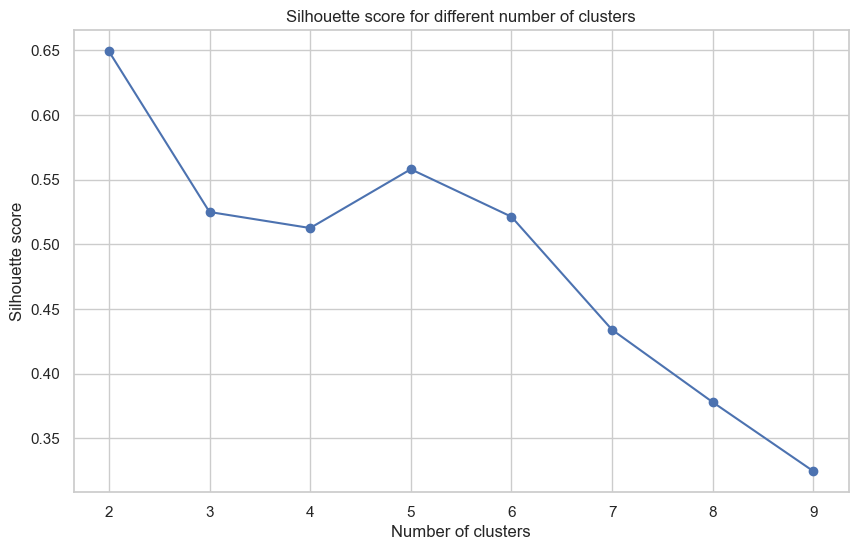

Optimal number of clusters: 2


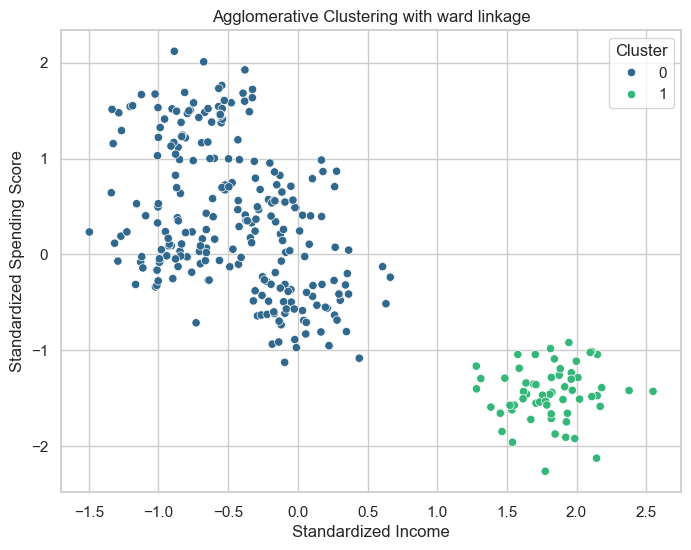

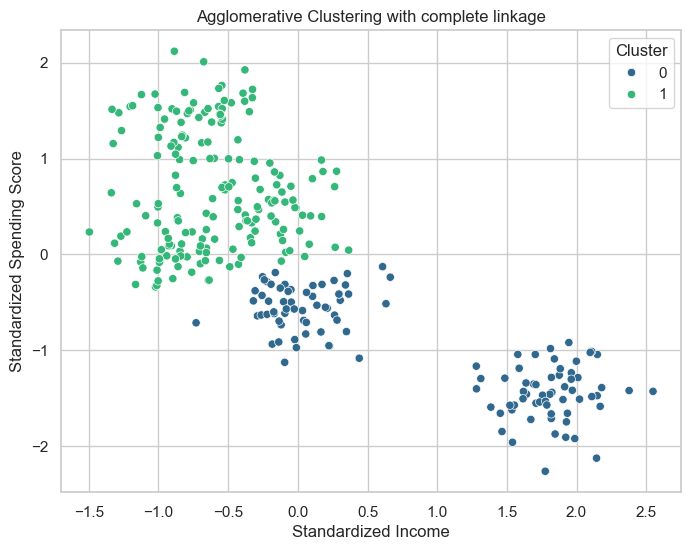

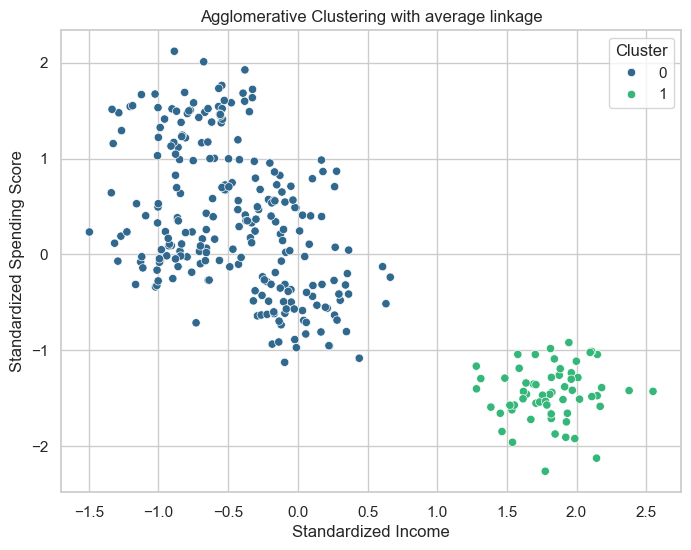

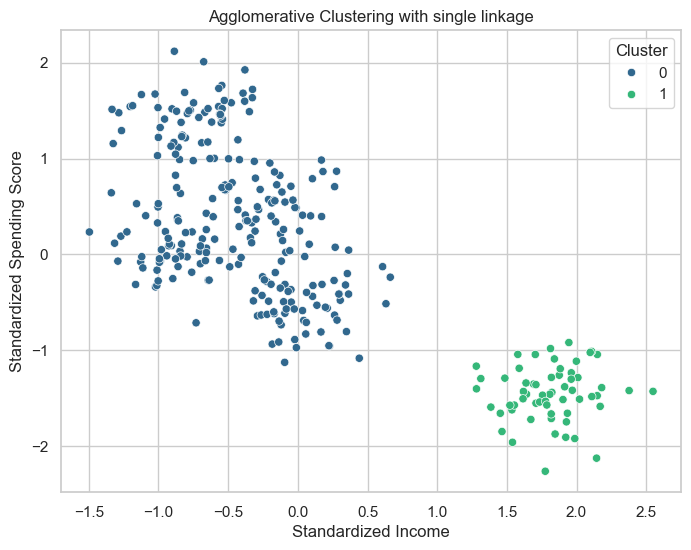

In [117]:
X, y_true = make_blobs(n_samples=300, centers=5, random_state=0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

silhouette_scores = []
for n_clusters in range(2, 10):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clustering.fit(X_scaled)
    labels = clustering.labels_
    silhouette_score_ = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_score_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette score for different number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

optimal_n_clusters = np.argmax(silhouette_scores) + 2
print(f'Optimal number of clusters: {optimal_n_clusters}')

linkage_methods = ['ward', 'complete', 'average', 'single']

for linkage_method in linkage_methods:
    clustering = AgglomerativeClustering(n_clusters=optimal_n_clusters, linkage=linkage_method)
    clustering.fit(X_scaled)
    labels = clustering.labels_

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, palette='viridis', legend='full')
    plt.title(f'Agglomerative Clustering with {linkage_method} linkage')
    plt.xlabel('Standardized Income')
    plt.ylabel('Standardized Spending Score')
    plt.legend(title='Cluster')
    plt.show()

**Висновки з завдання 13 (детальні)**

Можна зробити такі висновки:

1. Оптимальна кількість кластерів:
 * За критерієм силуету, оптимальна кількість кластерів для даного набору даних становить 5.
2. Агломеративне кластерування з методом Ward:
 * Створює щільні та добре відокремлені кластери.
3. Агломеративне кластерування з повним методом зв'язку:
 * Створює менш щільні кластери, які можуть відрізнятися розміром.
4. Агломеративне кластерування з середнім методом зв'язку:
 * Створює кластери, проміжні між методами Ward і повним зв'язком.
5. Агломеративне кластерування з одиничним методом зв'язку:
 * Створює менш щільні, витягнуті кластери, спочатку з'єднуючи найближчі точки.
 
Використовуючи оптимальну кількість кластерів (5), отримані результати кластеризації для кожного методу зв'язку показують, що всі методи можуть бути ефективними для цього набору даних, але з деякими відмінностями в якості та формі кластерів. Метод Ward створює найбільш щільні та добре відокремлені кластери, тоді як інші методи можуть створювати менш щільні або більш витягнуті кластери.